# DGV-PTTOT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGV_PTTOT_train.csv")
test_df = pd.read_csv("data/input/DGV_PTTOT_test.csv")
all_df = pd.concat([train_df, test_df])

## Regressione lineare
Il primo modello da considerare è la regressione lineare.

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
data = CosmoData(train_df, None, test_df)
reg = reg.fit(data.train_set()[0], data.train_set()[1])

test_res_lr = test_df.copy()
test_res_lr["target"] = test_res_lr.time_tot
test_res_lr["prediction"] = np.exp(reg.predict(data.test_set()[0]))
test_res_lr["residual"] = test_res_lr.target - test_res_lr.prediction
test_res_lr["abs_err"] = (test_res_lr.target - test_res_lr.prediction).abs()
test_res_lr["rel_err"] = test_res_lr.abs_err / test_res_lr.target
test_res_lr[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,139000.000000,139000.000000
mean,873.466872,0.564977
std,1843.901655,0.993323
min,0.002723,0.000008
25%,52.896496,0.196465
50%,186.631422,0.364840
75%,804.662836,0.571366
max,27868.380699,20.721802


In [3]:
print("RMSE:", np.sqrt((test_res_lr.abs_err ** 2).mean()))

RMSE: 2040.316943678347


Il grafico del tempo previsto e del tempo osservato mostra come la regressione lineare sottostimi i tempi più lunghi e come tale errore aumenti all'aumentare del tempo osservato.

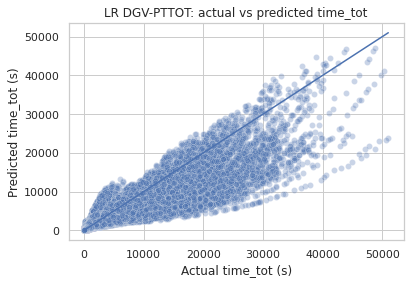

In [4]:
plt.title("LR DGV-PTTOT: actual vs predicted time_tot")
plt.plot([0, test_res_lr.target.max()], [0, test_res_lr.target.max()])
sns.scatterplot(data=test_res_lr, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgv-pttot/lr-correlazione-osservazione-previsione.pdf")
plt.show()

Possiamo notare la medesima cosa analizzando il grafico dei residui. Inoltre possiamo notare come si presente un pattern che suggerisce non linearità: il grafico del confronto tra previsione e residuo dovrebbe avere un aspetto casuale, proprio perché l'errore della previsione dovrebbe essere casuale.

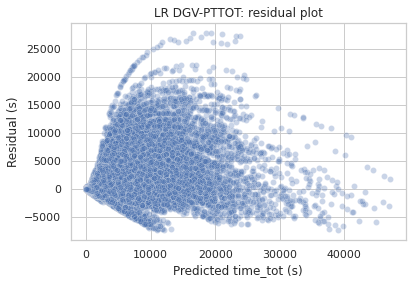

In [5]:
plt.title("LR DGV-PTTOT: residual plot")
sns.scatterplot(data=test_res_lr, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time_tot (s)")
plt.ylabel("Residual (s)")
plt.show()

Si può invece notare come la distribuzione dell'errore segua circa una distribuzione normale, al contrario dell'errore relativo.

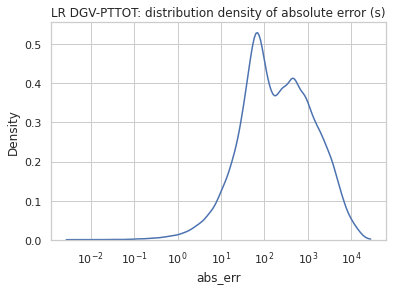

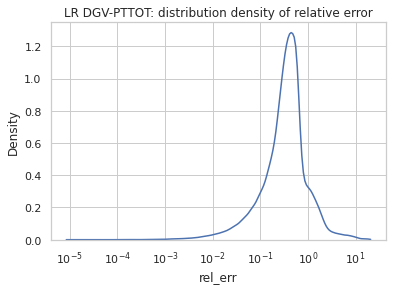

In [6]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.xscale("log")
plt.title("LR DGV-PTTOT: distribution density of absolute error (s)")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
plt.title("LR DGV-PTTOT: distribution density of relative error")
plt.show()

## DGV-PTTOT con HP tuning

Gli iperparametri del modello FCNN sono stati ottimizzati mediante Bayesian Optimization facendo 100 esperimenti.

In [7]:
with open("data/hpopt/DGV_PTTOT.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial

In [8]:
best["result"]["loss"]

172.6046102728819

In [9]:
cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
config = best["result"]["config"]

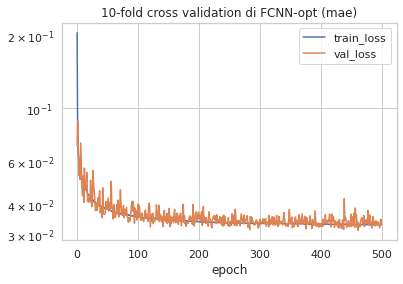

In [10]:
cv_res.groupby("epoch")[["train_loss", "val_loss"]].mean().plot(grid=True, logy=True)
plt.title(f"10-fold cross validation di FCNN-opt ({config['loss']})")
plt.show()

In [11]:
best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
print("Best epoch", best_epoch)

Best epoch 461


In [12]:
print(yaml.dump(config))

batch: 256
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 47
  - dropout: 0.0
    size: 49
  - dropout: 0.0
    size: 40
optimizer:
  lr: 0.0038099215615586793
  name: adam
  weight_decay: 0.03490142737360863



Il modello viene riaddetrato usando tutto il training set e valutato usando il test set.

In [13]:
import os.path
train_res_opt_file = "data/output/DGV_PTTOT_train_result.csv"
test_res_opt_file = "data/output/DGV_PTTOT_test_result.csv"
model_file = "data/model/DGV_PTTOT_model.pth"
if os.path.exists(train_res_opt_file) and os.path.exists(test_res_opt_file):
    print("Carico i risultati del modello da file")
else:
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_opt = model.fit(data, best_epoch)
    test_res_opt = model.test(data)
    model.save(model_file)
    train_res_opt.to_csv(train_res_opt_file, index=False)
    test_res_opt.to_csv(test_res_opt_file, index=False)
    
train_res_opt = pd.read_csv(train_res_opt_file)
test_res_opt = pd.read_csv(test_res_opt_file)

Carico i risultati del modello da file


<AxesSubplot:>

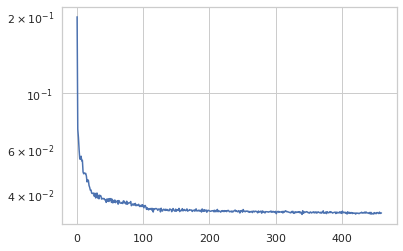

In [14]:
train_res_opt.train_loss.plot(grid=True, logy=True)

Dalla correlazione tra tempo osservato e previsto non si notano errori eccessivi: tutte le previsioni sono abbastanza vicine alla bisettrice (previsione esatta).

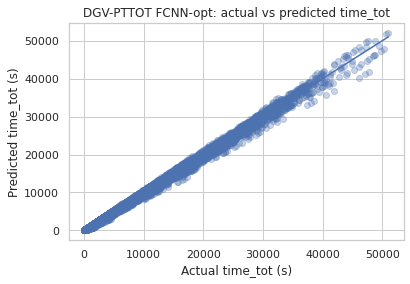

In [15]:
plt.title("DGV-PTTOT FCNN-opt: actual vs predicted time_tot")
plt.plot([test_res_opt.target.min(), test_res_opt.target.max()], [test_res_opt.target.min(), test_res_opt.target.max()])
plt.scatter(data=test_res_opt, x="target", y="prediction", alpha=0.3)
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Predicted time_tot (s)")
plt.savefig("tex/images/dgv-pttot/fcnn-opt-correlazione-osservazione-previsione.pdf")
plt.show()

Errore assoluto e relativo sono molto più contenuti rispetto a LR.

In [16]:
test_res_opt["abs_err"] = (test_res_opt.target - test_res_opt.prediction).abs()
test_res_opt["rel_err"] = test_res_opt.abs_err / test_res_opt.target
test_res_opt["residual"] = test_res_opt.target - test_res_opt.prediction
test_res_opt[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,139000.000000,1.390000e+05
mean,52.583493,3.339884e-02
std,153.926033,4.604786e-02
min,0.000011,4.348473e-07
25%,3.504526,9.946890e-03
50%,11.202888,2.182245e-02
75%,37.587463,4.003703e-02
max,6012.777344,7.752898e-01


Così come RMSE, che è inferiore di un ordine di grandezza:

In [17]:
print("RMSE:", np.sqrt((test_res_opt.abs_err ** 2).mean()))

RMSE: 162.659389709988


Il grafico dei residui mostra una eteroschedasticità contenuta, tranne per alcuni pattern lineari che potrebbero indicare delle anomalie nella previsione.

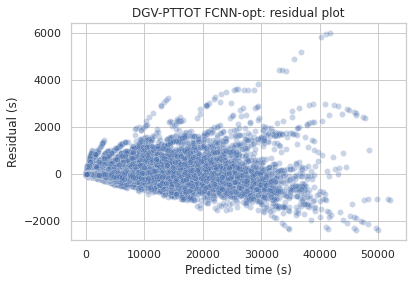

In [18]:
plt.title("DGV-PTTOT FCNN-opt: residual plot")
sns.scatterplot(data=test_res_opt, x="prediction", y="residual", alpha=0.3)
plt.xlabel("Predicted time (s)")
plt.ylabel("Residual (s)")
plt.savefig("tex/images/dgv-pttot/fcnn-opt-grafico-residui.pdf")
plt.show()

Qui sotto, possiamo notare come l'errore assoluto sia contenuto, ad eccezione per alcuni outlier, dovuti probabilmente ad anomalie.

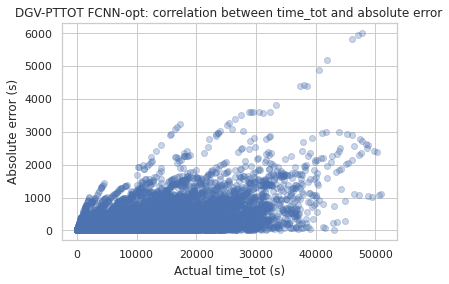

In [19]:
plt.scatter(data=test_res_opt, x="target", y="abs_err", alpha=0.3)
plt.title("DGV-PTTOT FCNN-opt: correlation between time_tot and absolute error")
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Absolute error (s)")
plt.savefig("tex/images/dgv-pttot/fcnn-opt-correlazione-osservazione-errore-assoluto.pdf")
plt.show()

L'errore relativo più alto riguarda le esecuzioni più brevi: questo è un comportamento desiderato, in quanto si è voluto privilegiare la minimizzazione dell'errore nel caso delle esecuzioni più lunghe (dove l'errore cala fino al 10% circa).

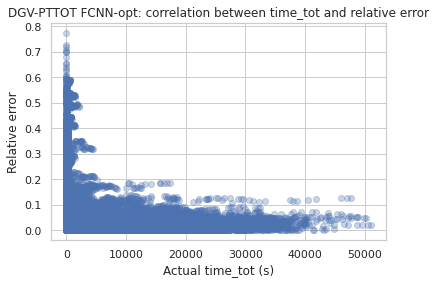

In [20]:
plt.scatter(data=test_res_opt, x="target", y="rel_err", alpha=0.3)
plt.title("DGV-PTTOT FCNN-opt: correlation between time_tot and relative error")
plt.xlabel("Actual time_tot (s)")
plt.ylabel("Relative error")
plt.savefig("tex/images/dgv-pttot/fcnn-opt-correlazione-osservazione-errore-relativo.pdf")
plt.show()

Qui vediamo la distribuzione dell'errore assoluto e relativo di LR e FCNN: possiamo notare come il secondo sia sensibilmente più preciso.

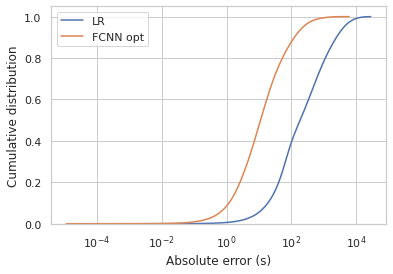

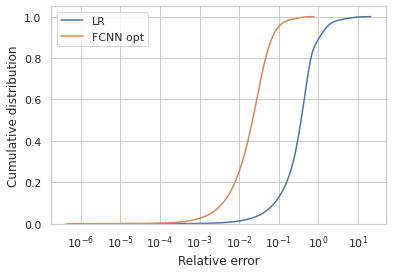

In [21]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pttot/cdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=True, cut=0, label="LR")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=True, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pttot/cdf-errore-relativo.pdf")
plt.legend()
plt.show()

Notiamo l'andamento unimodale del PDF di FCNN (sia assoluto che relativo): questo indica che l'errore è sostanzialmente casuale.

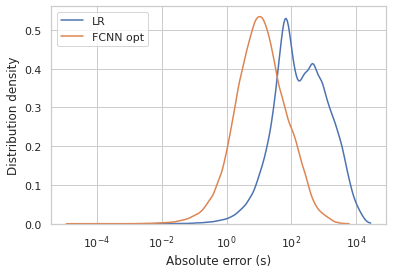

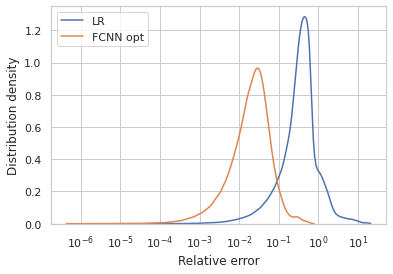

In [22]:
sns.kdeplot(data=test_res_lr, x="abs_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_opt, x="abs_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgv-pttot/pdf-errore-assoluto.pdf")
plt.show()

sns.kdeplot(data=test_res_lr, x="rel_err", log_scale=True, cumulative=False, cut=0, label="LR")
sns.kdeplot(data=test_res_opt, x="rel_err", log_scale=True, cumulative=False, cut=0, label="FCNN opt")
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgv-pttot/pdf-errore-relativo.pdf")
plt.legend()
plt.show()

## Conclusioni

FCNN ha prestazioni sensibilmente migliori rispetto a LR. In particolare, si può notare come il modello abbia un errore relativo contenuto (meno del 10% e minore del l'1% nel 95% dei casi) e come i valori più alti riguardino le esecuzioni più brevi, la cui previsione è meno critica.

In [23]:
test_res_opt[["abs_err", "rel_err"]].quantile([0.8, 0.9, 0.95, 0.98, 0.99])

,abs_err,rel_err
0.80,52.561816,0.046070
0.90,122.893213,0.067571
0.95,227.494238,0.096729
0.98,432.629395,0.158473
0.99,691.572305,0.254809


In [24]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE LR: 873.4668723050867
MAE FCNN opt: 52.5834932143208


In [25]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE LR: 2040.316943678347
RMSE FCNN opt: 162.659389709988


In [26]:
for name, df in zip(("LR", "FCNN opt"), (test_res_lr, test_res_opt)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE LR: 56.49774345164269
MAPE FCNN opt: 3.339884130376464
